<a href="https://colab.research.google.com/github/Matt-Chang/LLM---Detect-AI-Generated-Text/blob/main/Twisted_Prompts_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

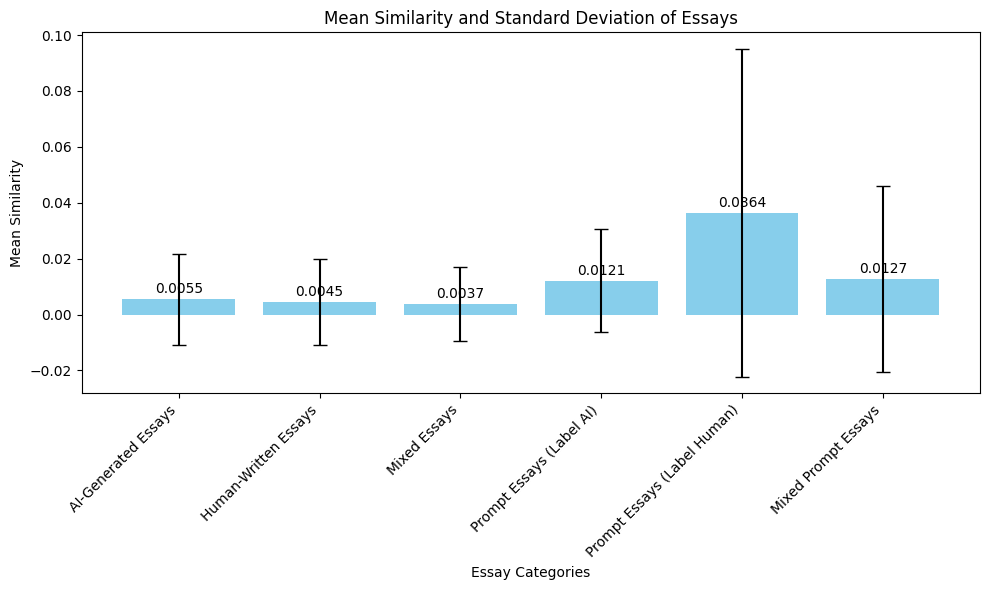

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['AI-Generated Essays','Human-Written Essays','Mixed Essays','Prompt Essays (Label AI)', 'Prompt Essays (Label Human)', 'Mixed Prompt Essays']

mean_similarity = [0.0055, 0.0045, 0.0037, 0.0121, 0.0364, 0.0127]
std_dev = [0.0163, 0.0154, 0.0133, 0.0185, 0.0587, 0.0332]

x = np.arange(len(categories))

# Plotting the data
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(x, mean_similarity, yerr=std_dev, capsize=5, color='skyblue')

# Adding labels and title
ax.set_xlabel('Essay Categories')
ax.set_ylabel('Mean Similarity')
ax.set_title('Mean Similarity and Standard Deviation of Essays')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right')

# Adding value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(yval, 4), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
# Install specific versions of the packages to avoid conflicts
!pip install torch==2.3.1+cu121
!pip install fsspec==2024.6.1
!pip install requests==2.31.0
!pip install pyarrow==14.0.1
!pip install datasets==2.20.0
!pip install pyspellchecker==0.7.1
!pip install SPARQLWrapper==1.8.5
!pip install shap==0.41.0
!pip install transformers==4.24.0

  Using cached fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.6.1-py3-none-any.whl (177 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.5.0
    Uninstalling fsspec-2024.5.0:
      Successfully uninstalled fsspec-2024.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
datasets 2.20.0 requires fsspec[http]<=2024.5.0,>=2023.1.0, but you have fsspec 2024.6.1 which is incompatible.
  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not cur

In [ ]:

import re
import nltk
import torch
import string
import spacy
import packaging
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from google.colab import drive
from scipy import sparse
from scipy.sparse import csr_matrix
from textblob import TextBlob
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from sklearn.decomposition import NMF
from torch.utils.data import Dataset
from collections import Counter
from sklearn.pipeline import Pipeline
from spellchecker import SpellChecker
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from SPARQLWrapper import SPARQLWrapper, JSON
from torch.utils.data import TensorDataset, DataLoader
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertModel
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
nltk.download('wordnet')

spell = SpellChecker()
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import the dataset from the competition
df_prompt = pd.read_csv('/content/drive/My Drive/llm-detect-ai-generated-text/train_prompts.csv')
df_train_essay = pd.read_csv('/content/drive/My Drive/llm-detect-ai-generated-text/train_essays.csv')

# Import the dataset created by other Kaggle contributors for balancing the dataset
# https://www.kaggle.com/code/awsaf49/detect-fake-text-kerasnlp-tf-torch-jax-train
ext_df1 = pd.read_csv('/content/drive/My Drive/llm-detect-ai-generated-text/extended_dataset/daigt/train_drcat_01.csv')
ext_df2 = pd.read_csv('/content/drive/My Drive/llm-detect-ai-generated-text/extended_dataset/daigt/train_drcat_02.csv')
ext_df3 = pd.read_csv('/content/drive/My Drive/llm-detect-ai-generated-text/extended_dataset/daigt/train_drcat_03.csv')
ext_df4 = pd.read_csv('/content/drive/My Drive/llm-detect-ai-generated-text/extended_dataset/daigt/train_drcat_04.csv')
ext_df5 = pd.concat([ext_df1, ext_df2, ext_df3, ext_df4], axis=0)  # Concatenate all the dataframes


# Dataset exploration

We can see that there is a data imbalance problem between AI and human essays.

There are 1375 human essays, whereas only 3 AI essays in the dataset.

Thus, the next step is to increase the size of the dataset to fix the problem.

In [ ]:
print(df_train_essay[df_train_essay['generated']==0]['generated'].value_counts())
print(df_train_essay[df_train_essay['generated']==1]['generated'].value_counts())

generated
0    1375
Name: count, dtype: int64
generated
1    3
Name: count, dtype: int64


Here, I simply checked the distribution of the prompt_id used in the dataset.

prompt_id 0 has been used 707 times. prompt_id 1 has been used 668 times in the dataset.

There is not so much difference in the dataset.

We will focus more on the content instead of the prompts.

In [ ]:
df_train_essay[df_train_essay['generated'] == 0]['prompt_id'].value_counts()

prompt_id
0    707
1    668
Name: count, dtype: int64

In [ ]:
value_counts = ext_df5['label'].value_counts()

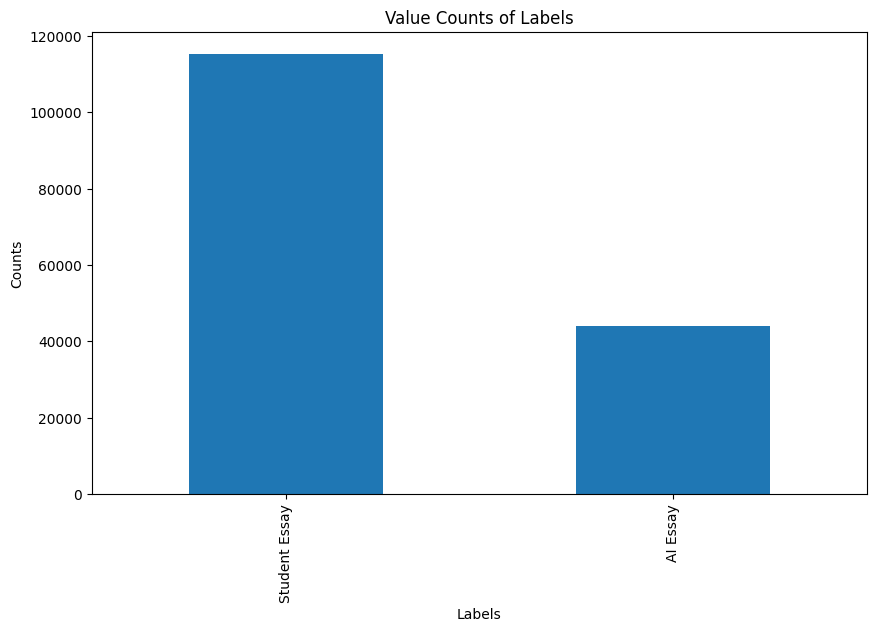

In [ ]:
# Plotting the value counts as a bar chart
plt.figure(figsize=(10, 6))  # Optional: set the figure size
value_counts.plot(kind='bar')

# Adding title and labels
plt.title('Value Counts of Labels')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(ticks=[0, 1], labels=['Student Essay', 'AI Essay'])  # Customizing x-axis labels

# Display the plot
plt.show()

In [ ]:
# Initial Data Overview
print("Dataset Information:")
ext_df5.info()

print("\nSummary Statistics:")
print(ext_df5.describe())

# Check for missing values
missing_values = ext_df5.isnull().sum()
print("\nMissing Values:")
print(missing_values)

# Visualize Missing Values
sns.heatmap(ext_df5.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

# Distribution of Numerical Features
print("\nHistograms of Numerical Features:")
ext_df5.hist(figsize=(15, 10), bins=20)
plt.show()

# Distribution of Categorical Features
categorical_features = ext_df5.select_dtypes(include=['object', 'category']).columns
print("\nBar Charts of Categorical Features:")
for feature in categorical_features:
    ext_df5[feature].value_counts().plot(kind='bar', title=feature)
    plt.show()

# Correlation Analysis
print("\nCorrelation Matrix:")
correlation_matrix = ext_df5.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Feature Relationships
print("\nPairplot of Numerical Features:")
sns.pairplot(ext_df5)
plt.show()

# Boxplot for Outliers Detection
numerical_features = ext_df5.select_dtypes(include=['int64', 'float64']).columns
print("\nBoxplots of Numerical Features:")
for feature in numerical_features:
    sns.boxplot(x=ext_df5[feature])
    plt.title(feature)
    plt.show()

In [ ]:
ext_df5[ext_df5['label'] == 1]['text'].iloc[0]
ext_df5[ext_df5['label'] == 0]['text'].iloc[0]

'There are alot reasons to keep our the despised method of choosing the President. The First reason is because Certainty of Outcome, in the text its states that "The reason is that the winning candidate\'s share of the Electoral College invariably exceeds his share of the popular vote. Another example from the text is "Obama, he recieved 61.7 percent of the electoral vote compared to only 51.3 percent of the popular votes cast for him and Romney... because all of the states award electoral votes on a winner-take-all basis.\n\nAnother reason is that the Electiral College requires a presidential candidate to have trans-regional appeal,in that case, no region has enough electoral votes to elect a president, a solid regional favorite such as Romney was in the South , has no reason to campaign in those states because of the poor economy and because its not a wealthy state, he wont be able to campaign heavily. So he left with no votes and would have to find his Electoral College votes in a m

In [ ]:
# data cleaning
df_train_essay = df_train_essay[['text','generated']]
df_train_essay.rename(columns={'generated':'label'}, inplace=True)

# we took a sample of 4000 from the label 0 (Human) and 5300 from the label 1
ext_df5_0 = ext_df5[ext_df5['label'] == 0].sample(43000)
ext_df5_1 = ext_df5[ext_df5['label'] == 1].sample(44000)

# concatenate the dataframes from the external data for the two labels
ext_df2 = pd.concat([ext_df5_0, ext_df5_1])
ext_df5_final = pd.concat([df_train_essay, ext_df2])

# drop the columns that are not needed
ext_df5_final.drop(columns=['essay_id','source','prompt','fold'],inplace=True)

# check the distribution of the labels once again
ext_df5_final['label'].value_counts()

#ext_df5_final.to_csv('C:\\Users\\user\\OneDrive - University of Sussex\\Second Semester\\Dissertation\\llm-detect-ai-generated-text\\extended_dataset\\dataset_balanced.csv', index=False)

<ipython-input-5-ba6880181501>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_essay.rename(columns={'generated':'label'}, inplace=True)


label
0    44375
1    44003
Name: count, dtype: int64

Import the dataset generated by the twisted prompts. In order to build a model that won't be fooled by the human-like generated essays, twisted prompts like "Based on this specific topic, generate an essay using this format of the writing style(an example essay is provided). Write the essay as if it were writen by a middle school student."

In [ ]:
prompt_essays = pd.read_csv('/content/drive/My Drive/llm-detect-ai-generated-text/extended_dataset/twisted_prompt.csv',encoding='latin1')

prompt_essays.drop(columns=['no.'],inplace=True)
prompt_essays.rename(columns={'content':'text'},inplace=True)
combine_dataset = pd.concat([ext_df5_final, prompt_essays],axis=0)

In [ ]:
combine_dataset

,text,label
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
93,Have you ever wondered what will happen if we ...,0
94,"""All of our development since world war II has...",0
95,In order to dramatically reduce greenhouse gas...,0
96,There are several advantages when you limit ca...,0


#### To gain insight  into how similar the AI-generated essays are, we randomly sampled a subset of 2,000 essays and calculated the pairwise 3-gram cosine similarities for all possible pairs. We then looked at the share of pairs that exceed a given similarity threshold of 0.05.

In [ ]:
ext_df5_final_0_5000 = ext_df5_final[ext_df5_final['label'] == 0].sample(5000)
ext_df5_final_1_5000 = ext_df5_final[ext_df5_final['label'] == 1].sample(5000)
mixed_essays = pd.concat([ext_df5_final[ext_df5_final['label'] == 0].sample(2500),ext_df5_final[ext_df5_final['label'] == 1].sample(2500)],axis=0)
prompt_essays_1 = prompt_essays[prompt_essays['label']==1]
prompt_essays_0 = prompt_essays[prompt_essays['label']==0]
mix_prompt_essays = pd.concat([prompt_essays_0,prompt_essays_1],axis=0)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import itertools

# Define a function to calculate cosine similarities and statistics
def calculate_statistics(essays):
    vectorizer = CountVectorizer(ngram_range=(3, 3))  # 3-grams
    X = vectorizer.fit_transform(essays)
    cos_similarities = cosine_similarity(X)

    # Get all pairwise similarities excluding self-pairs
    pairs = list(itertools.combinations(range(len(essays)), 2))
    similarity_scores = [cos_similarities[i, j] for i, j in pairs]

    # Calculate mean and standard deviation
    mean_similarity = np.mean(similarity_scores)
    std_similarity = np.std(similarity_scores)

    return mean_similarity, std_similarity, similarity_scores

# Calculate statistics for each group
ai_mean, ai_std, ai_scores = calculate_statistics(list(ext_df5_final_1_5000['text']))
human_mean, human_std, human_scores = calculate_statistics(list(ext_df5_final_0_5000['text']))
mixed_mean, mixed_std, mixed_scores = calculate_statistics(list(mixed_essays['text']))
prompt_essays_1_mean, prompt_essays_1_std, prompt_essays_1_scores = calculate_statistics(list(prompt_essays_1['text']))
prompt_essays_0_mean, prompt_essays_0_std, prompt_essays_0_scores = calculate_statistics(list(prompt_essays_0['text']))
mix_prompt_essays_mean, mix_prompt_essays_std, mix_prompt_essays_scores = calculate_statistics(list(mix_prompt_essays['text']))

# Print results
print(f"AI-Generated Essays: Mean Similarity = {ai_mean:.4f}, Std Dev = {ai_std:.4f}")
print(f"Human-Written Essays: Mean Similarity = {human_mean:.4f}, Std Dev = {human_std:.4f}")
print(f"Mixed Essays: Mean Similarity = {mixed_mean:.4f}, Std Dev = {mixed_std:.4f}")
print(f"Prompt Essays (Label AI): Mean Similarity = {prompt_essays_1_mean:.4f}, Std Dev = {prompt_essays_1_std:.4f}")
print(f"Prompt Essays (Label Human): Mean Similarity = {prompt_essays_0_mean:.4f}, Std Dev = {prompt_essays_0_std:.4f}")
print(f"Mixed Prompt Essays: Mean Similarity = {mix_prompt_essays_mean:.4f}, Std Dev = {mix_prompt_essays_std:.4f}")

AI-Generated Essays: Mean Similarity = 0.0055, Std Dev = 0.0163
Human-Written Essays: Mean Similarity = 0.0045, Std Dev = 0.0154
Mixed Essays: Mean Similarity = 0.0037, Std Dev = 0.0133
Prompt Essays (Label AI): Mean Similarity = 0.0121, Std Dev = 0.0185
Prompt Essays (Label Human): Mean Similarity = 0.0364, Std Dev = 0.0587
Mixed Prompt Essays: Mean Similarity = 0.0127, Std Dev = 0.0332


If the proportion of AI-generated essay pairs exceeding the 0.05 threshold was significantly higher than that of human-written essays, it would suggest that the AI model tends to produce more repetitive content. Conversely, a low proportion would indicate that the AI model generates diverse and unique responses.

The human-written essays served as a control group. The expected lower proportion of similar pairs among these essays would affirm that human-authored content is typically more varied.

It makes sense to see, in general, the AI content has higher similiarity score than human content. For the twisted prompt content, since AI content was generated by different prompts, lower similiarity score is expected.

# Experiment 1 (TFIDF and BERT word representations and feed to the LogisticRegression and BERT model.)


Below is the reuslt of using the simple BoW model to classify the Ai and human essays.

The result shows that around 98 percent of the eassys can be predicted correctly.

Later, we will try to use the BERT model for the same test.

In [ ]:
df_f_t_20.reset_index(drop=True)

,feature,coefficient
0,point,-3.684649
1,text,-3.792447
2,driving,-4.121286
3,elector,-4.167391
4,studentname,-4.425253
5,would,-4.482733
6,venus,-4.547473
7,paragraph,-4.601254
8,human,-4.667036
9,get,-4.696304


In [ ]:
# Function to preprocess text
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

ext_df5_final['preprocessed_text'] = ext_df5_final['text'].apply(preprocess_text)

# Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the preprocessed text to a TF-IDF representation
X = vectorizer.fit_transform(ext_df5_final['preprocessed_text'])

# Split the ext_df5_final
X_train, X_val, y_train, y_val = train_test_split(X, ext_df5_final['label'], test_size=0.2, random_state=42)

print("Revised ext_df5_final preparation complete. Features and labels ready for model training.")

# Train binary classifier
binary_classifier = LogisticRegression(random_state=42)
binary_classifier.fit(X_train, y_train)

# Evaluate binary classifier
binary_predictions = binary_classifier.predict(X_val)
binary_classification_report = classification_report(y_val, binary_predictions, target_names=['Human essays', 'AI essays'], output_dict=True)

# Convert the classification report to DataFrame
report_df = pd.DataFrame(binary_classification_report).transpose()
print(report_df)

# Feature importance
feature_names = vectorizer.get_feature_names_out()
coefficients = binary_classifier.coef_[0]
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', ascending=False)

# Function to count specific words in a column of a dataframe
def count_specific_words(dataframe, column, words):
    words = [word.lower() for word in words]
    all_text = ' '.join(dataframe[column])
    words_in_text = all_text.split()
    word_counts = Counter(words_in_text)
    specific_word_counts = {word: word_counts[word] for word in words}
    return specific_word_counts

# List of words to count
words_to_count = [
    "conclusion", "additionally", "important", "provide", "essay", "potential", "name", "like",
    "super", "firstly", "hey", "theyre", "youre", "plus", "cool", "lead", "impact",
    "significant", "fair", "climate", "home", "kid", "driving", "paragraph", "self",
    "elector", "venus", "get", "studentname", "would", "human", "agree", "reason",
    "although", "going", "student", "many", "car", "people", "go"
]

# Count the occurrences of the specific words in the preprocessed_text column for AI and Human labels
AI_word_counts = count_specific_words(ext_df5_final[ext_df5_final['label'] == 1], 'preprocessed_text', words_to_count)
Human_word_counts = count_specific_words(ext_df5_final[ext_df5_final['label'] == 0], 'preprocessed_text', words_to_count)

# Create a DataFrame to organize the counts
df = pd.DataFrame({
    'Word': words_to_count,
    'AI': [AI_word_counts[word] for word in words_to_count],
    'Human': [Human_word_counts[word] for word in words_to_count]
})

df_f_20 = pd.DataFrame(feature_importance.head(20))
df_f_t_20 = pd.DataFrame(feature_importance.tail(20))
df_con_20 = pd.concat([df_f_20,df_f_t_20])
df_con_20.reset_index(drop=True,inplace=True)
df_combined = pd.merge(df, df_con_20, left_on='Word', right_on='feature', how='left')

df_combined.drop(columns=['feature'],inplace=True)

df_combined


Revised ext_df5_final preparation complete. Features and labels ready for model training.
              precision    recall  f1-score      support
Human essays   0.985797  0.993736  0.989750   8940.00000
AI essays      0.993536  0.985348  0.989425   8736.00000
accuracy       0.989590  0.989590  0.989590      0.98959
macro avg      0.989667  0.989542  0.989588  17676.00000
weighted avg   0.989622  0.989590  0.989590  17676.00000


,Word,AI,Human,coefficient
0,conclusion,25529,9604,8.897483
1,additionally,19780,830,8.017701
2,important,47219,14109,7.661081
3,provide,22098,3300,6.232788
4,essay,14758,1944,6.274360
5,potential,16858,1572,6.023548
6,name,5471,1505,6.186756
7,like,86603,62270,4.983085
8,super,10380,492,5.286365
9,firstly,7640,527,4.982234


In [ ]:
import pandas as pd
!pip install datasets
from datasets import Dataset
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the texts and create a HuggingFace Dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

# Convert the DataFrame to a HuggingFace Dataset
dataset = Dataset.from_pandas(ext_df5_final)
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column('label', 'labels')
tokenized_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Split the dataset into training and validation sets
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
val_dataset = train_test_split['test']

# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch'
)

# Define the Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()

# Get predictions
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.argmax(-1)

# Classification report
y_true = val_dataset['labels']
print(classification_report(y_true, preds, target_names=['Human essays', 'AI essays']))

Map:   0%|          | 0/88378 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.007900,0.050630
2,0.000200,0.025814
3,0.000100,0.018197


              precision    recall  f1-score   support

Human essays       1.00      0.99      1.00      8811
   AI essays       0.99      1.00      1.00      8865

    accuracy                           1.00     17676
   macro avg       1.00      1.00      1.00     17676
weighted avg       1.00      1.00      1.00     17676



AI content: Words like conclusion / important / additionally / essay are often used in the AI content.

# Experiment 2 (Twisted Prompts analysis )

In [ ]:
# List of pronouns
pronouns = set([
    'i', 'me', 'my', 'mine', 'myself',
    'we', 'us', 'our', 'ours', 'ourselves',
    'you', 'your', 'yours', 'yourself', 'yourselves',
    'he', 'him', 'his', 'himself',
    'she', 'her', 'hers', 'herself',
    'it', 'its', 'itself',
    'they', 'them', 'their', 'theirs', 'themselves'
])

# Function to check word length
def check_word_length(text):
    words = word_tokenize(text)
    if len(words) == 0:
        return 0
    avg_word_length = np.mean([len(word) for word in words])
    return avg_word_length

# Function to check sentence length
def check_sentence_length(text):
    sentences = sent_tokenize(text)
    if len(sentences) == 0:
        return 0
    avg_sentence_length = np.mean([len(sentence) for sentence in sentences])
    return avg_sentence_length

# Function to check pronoun usage
def check_pronouns(text):
    words = word_tokenize(text.lower())
    pronoun_count = sum(1 for word in words if word in pronouns)
    return pronoun_count

# Function to check spelling mistakes
def check_spelling(text):
    words = word_tokenize(text)
    misspelled = spell.unknown(words)
    return len(misspelled)

# Function to check passive voice
def check_passive_voice(text):
    sentences = sent_tokenize(text)
    passive_sentences = 0
    for sentence in sentences:
        words = word_tokenize(sentence)
        tagged = nltk.pos_tag(words)
        if 'VBN' in [tag for word, tag in tagged] and any(aux in [word for word, tag in tagged] for aux in ['was', 'were', 'is', 'been']):
            passive_sentences += 1
    return passive_sentences

# NER function to count named entities
def count_named_entities(text):
    doc = nlp(text)
    entity_count = len(doc.ents)
    return entity_count

# Human Authorship Score
def presence_score(text):
    doc = nlp(text)
    personal_pronouns = sum(1 for token in doc if token.pos_ == "PRON" and token.lower_ in pronouns)
    informal_phrases = sum(1 for token in doc if token.lower_ in ["hey", "lol", "omg", "brb", "btw", "idk", "jk", "tbh", "tbt", "ttyl", "wtf", "yolo", "smh", "lmao", "rofl", "omfg", "oml", "omw", "ofc", "fml", "imo", "imho", "irl", "nvm", "tmi", "tldr", "ygm", "yolo", "yoloing"])
    score = personal_pronouns + informal_phrases
    return score

# Philosophical Sentiment Score
def sentiment_score(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    return sentiment

# Abstract Concepts Score
abstract_concepts_set = {"love", "freedom", "justice", "beauty", "truth", "ethics", "philosophy", "morality", "knowledge", "wisdom",
                         "intelligence", "consciousness", "happiness", "suffering", "empathy", "compassion", "altruism", "creativity",
                         "imagination", "curiosity", "intuition", "spirituality", "faith", "religion", "belief", "doubt", "fear", "anxiety",
                         "depression", "stress", "trauma", "healing", "forgiveness", "reconciliation", "redemption", "salvation", "damnation",
                         "sin", "virtue", "vice", "sin", "evil", "good", "bad", "right", "wrong", "justice", "injustice", "equality",
                         "inequality", "free","will", "determinism", "fate", "destiny", "time", "space", "reality", "illusion", "dream",
                         "nightmare", "life", "death", "birth", "existence", "essence", "nature", "nurture", "mind", "body", "soul",
                         "spirit", "consciousness", "unconsciousness", "subconsciousness", "ego", "id", "superego", "self", "other",
                         "us", "them", "we", "they", "me", "you", "he", "she", "it", "they", "we", "us", "them", "this", "that", "here",
                         "there", "now", "then", "always", "never", "sometimes", "maybe", "perhaps", "possibly", "impossible",
                         "possible", "certain", "uncertain", "doubtful", "doubtless", "sure", "unsure", "true", "false", "real",
                         "unreal", "actual", "potential", "past", "present", "future", "beginning", "middle", "end", "start",
                         "stop", "go", "come", "arrive", "leave", "stay", "move", "change", "same", "different", "similar", "opposite",
                         "equal", "unequal", "greater", "lesser", "more"}

def concept_score(text):
    doc = nlp(text)
    abstract_concepts = sum(1 for token in doc if token.lemma_.lower() in abstract_concepts_set)
    return abstract_concepts


# Metaphors Score
def metaphor_score(text):
    doc = nlp(text)
    metaphors = sum(1 for sent in doc.sents if re.search(r'\b(as\s+\w+\s+as|like\s+a|is\s+a\s+)\b', sent.text, re.IGNORECASE))
    return metaphors

# Multi-dimensional Analysis Function
def multi_dimensional_analysis(text):
    scores = {
        'word_length': check_word_length(text),
        'sentence_length': check_sentence_length(text),
        'pronouns': check_pronouns(text),
        'spelling': check_spelling(text),
        'passive_voice': check_passive_voice(text),
        'named_entities': count_named_entities(text),
        'human_authorship': presence_score(text),
        'philosophical_sentiment': sentiment_score(text),
        'abstract_concepts': concept_score(text),
        'metaphors': metaphor_score(text)
    }
    return scores

# features usage
features = [
    'word_length', 'sentence_length', 'pronouns', 'spelling', 'passive_voice',
    'named_entities', 'human_authorship', 'philosophical_sentiment',
    'abstract_concepts', 'metaphors']


### Twisted prompts AI essays with non-twisted prompts AI essays comparsion\\

In [ ]:
prompt_essays = pd.read_csv('/content/drive/My Drive/llm-detect-ai-generated-text/extended_dataset/twisted_prompt.csv',encoding='latin1')
prompt_essays.drop(columns=['no.'],inplace=True)
prompt_essays.rename(columns={'content':'text'},inplace=True)

ext_df5_final_1_100 = ext_df5_final[ext_df5_final['label'] == 1].sample(50)
ext_df5_final_1_100['label'] = 0 # 0 is non twisted prompted AI essays
prompt_essays_1 = prompt_essays[prompt_essays['label']==1]

mix_AI_prompt_essays = pd.concat([ext_df5_final_1_100,prompt_essays_1],axis=0)
mix_AI_prompt_essays.reset_index(drop=True,inplace=True)

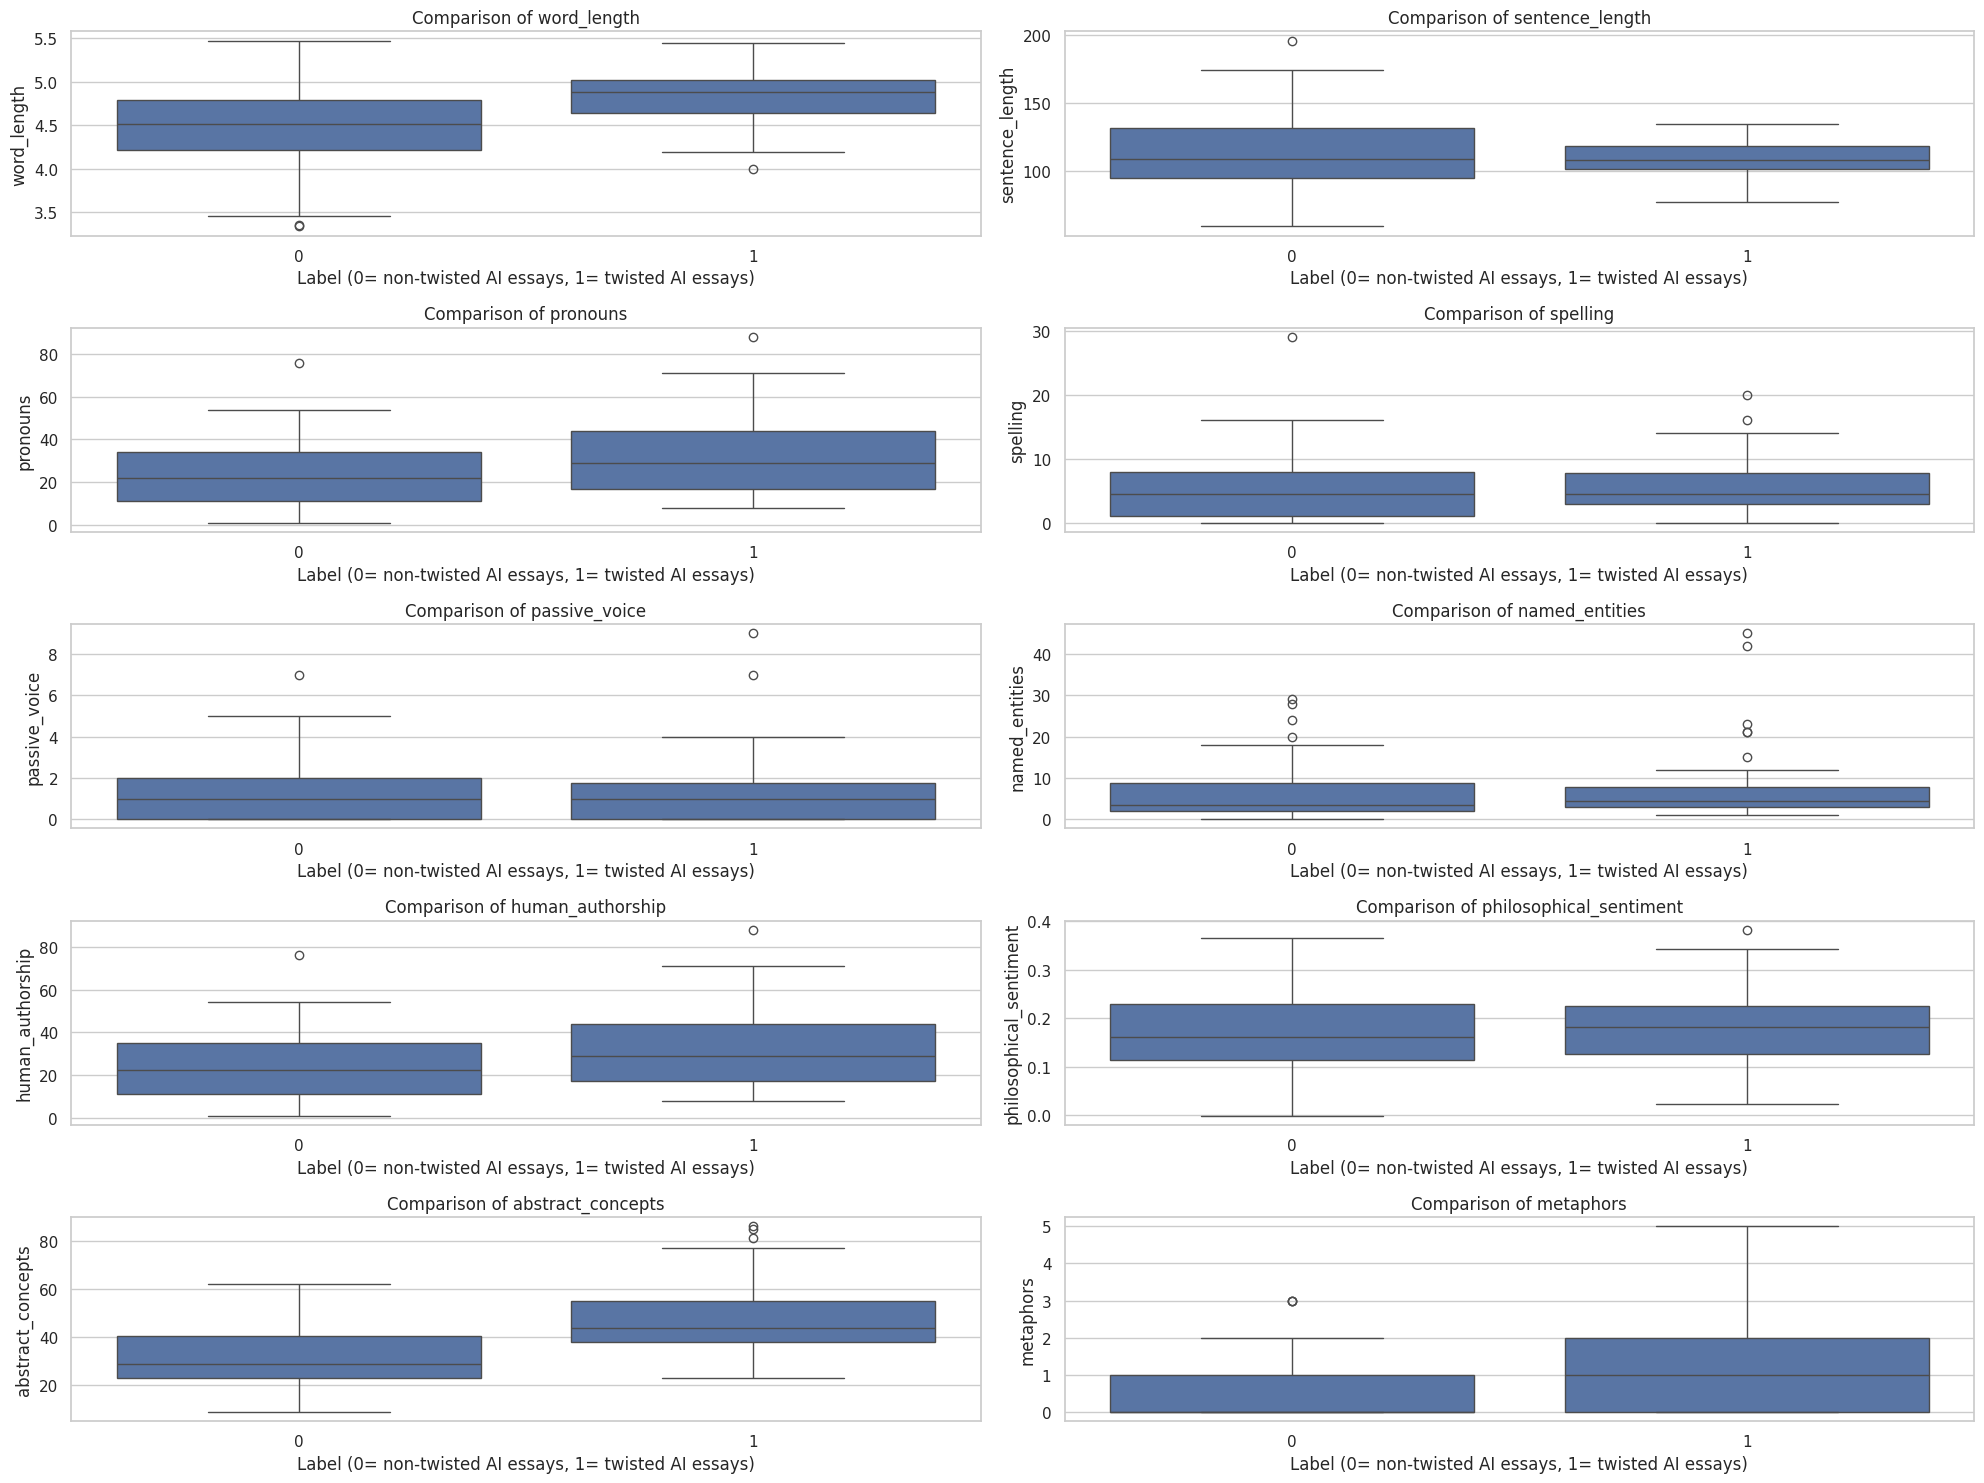

In [ ]:
def plot_box_plots(data, features):
    # Apply the analysis function
    data['analysis'] = data['text'].apply(multi_dimensional_analysis)
    analysis_df = pd.json_normalize(data['analysis'])
    data = data.drop(columns=['analysis']).join(analysis_df)
    # Set the style of the visualization
    sns.set(style="whitegrid")

    # Create subplots
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 15))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.boxplot(x='label', y=feature, data=data, ax=axes[i])
        axes[i].set_title(f'Comparison of {feature}')
        axes[i].set_xlabel('Label (0= non-twisted AI essays, 1= twisted AI essays)')
        axes[i].set_ylabel(feature)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot box plots
plot_box_plots(mix_AI_prompt_essays, features)


### Twisted prompts AI essays with human essays comparsion

In [ ]:
prompt_essays = pd.read_csv('/content/drive/My Drive/llm-detect-ai-generated-text/extended_dataset/twisted_prompt.csv',encoding='latin1')
prompt_essays.drop(columns=['no.'],inplace=True)
prompt_essays.rename(columns={'content':'text'},inplace=True)

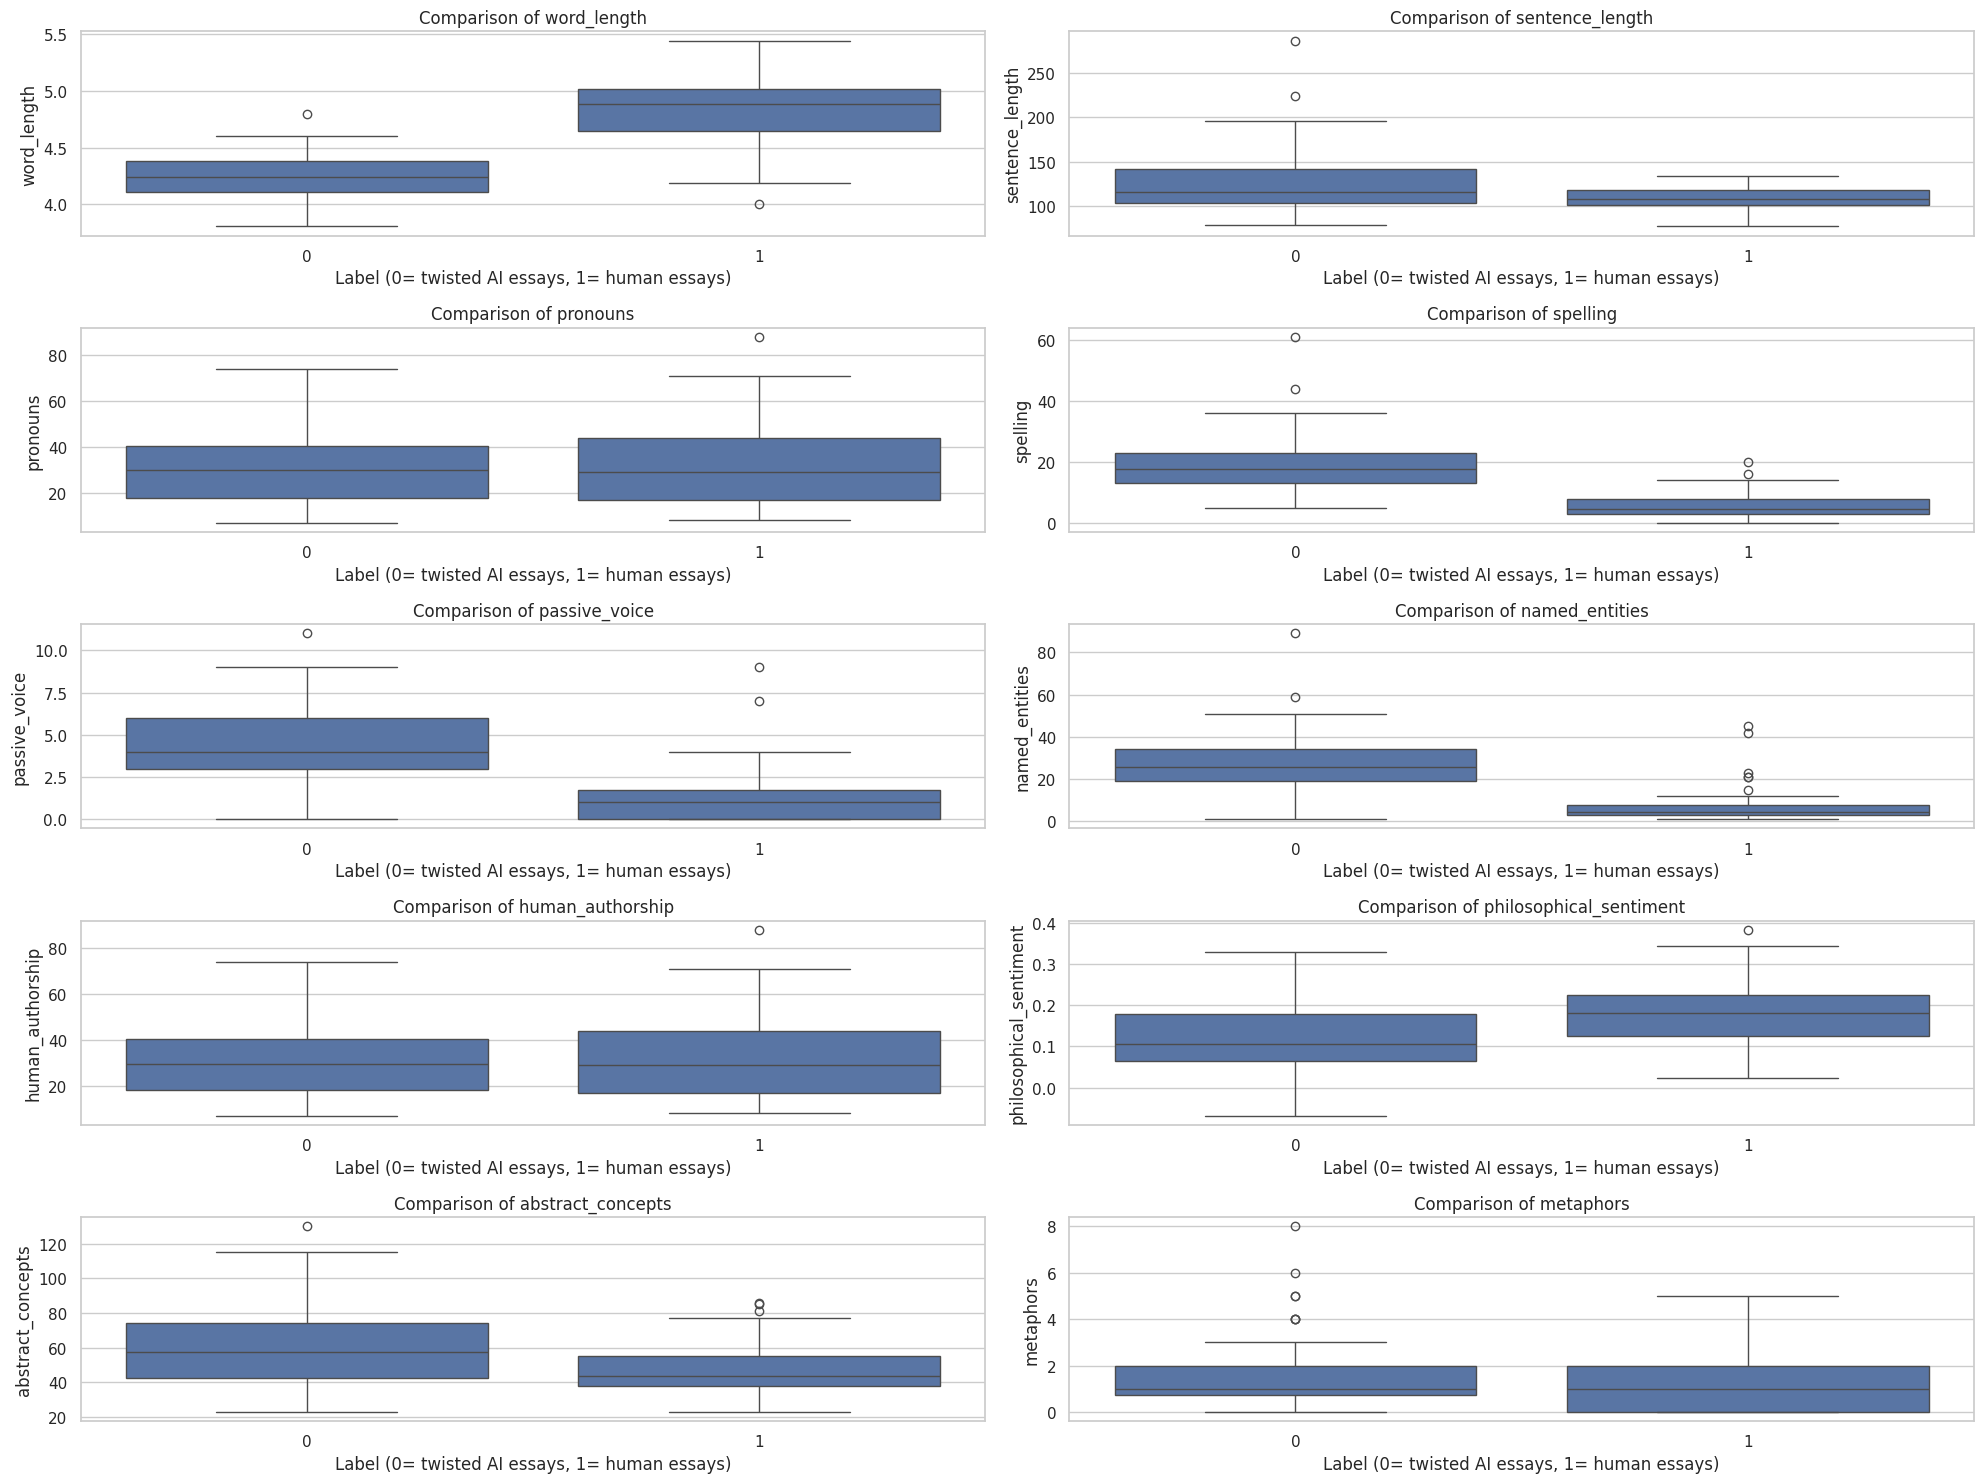

In [ ]:
def plot_box_plots(data, features):
    # Apply the analysis function
    data['analysis'] = data['text'].apply(multi_dimensional_analysis)
    analysis_df = pd.json_normalize(data['analysis'])
    data = data.drop(columns=['analysis']).join(analysis_df)
    # Set the style of the visualization
    sns.set(style="whitegrid")

    # Create subplots
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 15))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.boxplot(x='label', y=feature, data=data, ax=axes[i])
        axes[i].set_title(f'Comparison of {feature}')
        axes[i].set_xlabel('Label (0= twisted AI essays, 1= human essays)')
        axes[i].set_ylabel(feature)

    # Adjust layout
    plt.tight_layout()
    plt.show()
# Plot box plots
plot_box_plots(prompt_essays, features)

In [ ]:
def plot_box_plots(data, features):
    # Apply the analysis function
    data['analysis'] = data['text'].apply(multi_dimensional_analysis)
    analysis_df = pd.json_normalize(data['analysis'])
    data = data.drop(columns=['analysis']).join(analysis_df)
    # Set the style of the visualization
    sns.set(style="whitegrid")

    # Create subplots
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 15))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.boxplot(x='label', y=feature, data=data, ax=axes[i])
        axes[i].set_title(f'Comparison of {feature}')
        axes[i].set_xlabel('Label (0= non-twisted AI essays, 1= human essays)')
        axes[i].set_ylabel(feature)

    # Adjust layout
    plt.tight_layout()
    plt.show()

### non-Twisted prompts AI essays with human essays comparsion

plot_box_plots(ext_df5_final, features)


# Experiment 3 Tf-idf, BERT vector representation, and feature extraction concatenation

In [ ]:
combine_dataset['analysis'] = combine_dataset['text'].apply(multi_dimensional_analysis)
analysis_df = pd.json_normalize(combine_dataset['analysis'])
combine_dataset = combine_dataset.drop(columns=['analysis']).join(analysis_df)
combine_dataset_extened_features = combine_dataset.drop(columns=['text'])
combine_dataset_extened_features.to_csv('combine_dataset_extened_features.csv',index=False)
combine_dataset_extened_features.drop('essay_id',inplace=True,axis=1)

In [ ]:
combine_dataset_extened_features = pd.read_csv('/content/combine_dataset_extened_features.csv')
combine_dataset_extened_features.drop(['essay_id','label','source','prompt','fold'],inplace=True,axis=1)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available. Using GPU.")
else:
    device = torch.device('cpu')
    print("GPU not available. Using CPU.")

GPU is available. Using GPU.


In [ ]:
extended_features

array([[3.95853270e+00, 9.99666667e+01, 3.80000000e+01, ...,
        1.97170686e-01, 5.80000000e+01, 0.00000000e+00],
       [3.95853270e+00, 9.99666667e+01, 3.80000000e+01, ...,
        1.97170686e-01, 5.80000000e+01, 0.00000000e+00],
       [3.94422311e+00, 9.32307692e+01, 2.90000000e+01, ...,
        1.67167832e-01, 3.60000000e+01, 3.00000000e+00],
       ...,
       [4.45533141e+00, 1.31357143e+02, 1.00000000e+01, ...,
        1.44696970e-01, 3.70000000e+01, 1.00000000e+00],
       [3.95260664e+00, 8.06400000e+01, 4.70000000e+01, ...,
        8.89583333e-02, 6.20000000e+01, 2.00000000e+00],
       [3.41795666e+00, 1.07307692e+02, 3.20000000e+01, ...,
        1.88271605e-02, 4.40000000e+01, 1.00000000e+00]])

In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Preprocess text function
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

combine_dataset['preprocessed_text'] = combine_dataset['text'].apply(preprocess_text)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=500)
X_tfidf = tfidf_vectorizer.fit_transform(combine_dataset['preprocessed_text']).toarray()

# Initialize the BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Function to get BERT embeddings for a batch
def get_bert_embeddings_batch(texts):
    inputs = bert_tokenizer(texts, return_tensors='pt', truncation=True, padding=True, max_length=512, add_special_tokens=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to the correct device
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

# Custom Dataset class to handle text data
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

# Generate BERT embeddings for all texts in batches
batch_size = 32
X_bert = []

text_dataset = TextDataset(combine_dataset['preprocessed_text'].tolist())
dataloader = DataLoader(text_dataset, batch_size=batch_size, shuffle=False)

for batch in dataloader:
    embeddings = get_bert_embeddings_batch(batch)
    X_bert.append(embeddings)

X_bert = np.vstack(X_bert)

# Check the shape of combine_dataset_extened_features and align if necessary
extended_features = combine_dataset_extened_features.values  # Convert DataFrame to numpy array
if len(extended_features) != len(combine_dataset):
    raise ValueError("Extended features and dataset length mismatch")

# Concatenate TF-IDF and BERT features
X_combined = np.hstack((X_tfidf, X_bert, extended_features))

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_combined, combine_dataset['label'], test_size=0.2, random_state=22)

print("Revised data preparation complete. Features and labels are ready for model training.")

# Neural network model for classification
class CombinedFeaturesNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CombinedFeaturesNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Convert the datasets to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
input_size = X_combined.shape[1]
num_classes = len(np.unique(combine_dataset['label']))
model = CombinedFeaturesNN(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    model.eval()
    total_val_loss = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct / len(val_dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

print("Training complete.")

# Save the model
model_save_path = 'combined_features_nn_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Evaluate the model
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=['Human essays', 'AI essays']))

Epoch 1/10, Train Loss: 0.3626, Val Loss: 0.1490, Val Accuracy: 0.9437
Epoch 2/10, Train Loss: 0.1469, Val Loss: 0.0893, Val Accuracy: 0.9700
Epoch 3/10, Train Loss: 0.1040, Val Loss: 0.0712, Val Accuracy: 0.9761
Epoch 4/10, Train Loss: 0.0853, Val Loss: 0.0650, Val Accuracy: 0.9796
Epoch 5/10, Train Loss: 0.0756, Val Loss: 0.0557, Val Accuracy: 0.9810
Epoch 6/10, Train Loss: 0.0691, Val Loss: 0.0519, Val Accuracy: 0.9823
Epoch 7/10, Train Loss: 0.0608, Val Loss: 0.0595, Val Accuracy: 0.9830
Epoch 8/10, Train Loss: 0.0577, Val Loss: 0.0510, Val Accuracy: 0.9840
Epoch 9/10, Train Loss: 0.0546, Val Loss: 0.0450, Val Accuracy: 0.9849
Epoch 10/10, Train Loss: 0.0532, Val Loss: 0.0419, Val Accuracy: 0.9866
Training complete.
Model saved to combined_features_nn_model.pth
              precision    recall  f1-score   support

Human essays       0.99      0.99      0.99      5959
   AI essays       0.99      0.97      0.98      2502

    accuracy                           0.99      8461
   mac

In [ ]:
import joblib
# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')

# Save the custom features scaler
joblib.dump(extended_features, 'custom_features_scaler.joblib')

['custom_features_scaler.joblib']

In [ ]:
extended_features.shape

(42304, 10)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from textblob import TextBlob

nltk.download('punkt')

def score_feature(value, thresholds):
    for i, threshold in enumerate(thresholds):
        if value <= threshold:
            return i + 1
    return len(thresholds) + 1

def benchmark_scores():
    return {
        'word_length': [4.0, 4.5, 5.0, 5.5, 6.0],
        'sentence_length': [15, 20, 25, 30, 35],
        'pronouns': [2, 5, 10, 15, 20],
        'spelling': [5, 10, 15, 20, 25],
        'passive_voice': [1, 2, 3, 4, 5],
        'named_entities': [2, 5, 10, 15, 20],
        'human_authorship': [5, 10, 15, 20, 25],
        'philosophical_sentiment': [0.1, 0.2, 0.3, 0.4, 0.5],
        'abstract_concepts': [5, 10, 15, 20, 25],
        'metaphors': [1, 2, 3, 4, 5]
    }

def multi_dimensional_analysis(text):
    scores = {
        'word_length': check_word_length(text),
        'sentence_length': check_sentence_length(text),
        'pronouns': check_pronouns(text),
        'spelling': check_spelling(text),
        'passive_voice': check_passive_voice(text),
        'named_entities': count_named_entities(text),
        'human_authorship': presence_score(text),
        'philosophical_sentiment': sentiment_score(text),
        'abstract_concepts': concept_score(text),
        'metaphors': metaphor_score(text)
    }
    return scores

def score_essay(text):
    feature_scores = multi_dimensional_analysis(text)
    benchmarks = benchmark_scores()

    total_score = 0
    for feature, value in feature_scores.items():
        feature_score = score_feature(value, benchmarks[feature])
        total_score += feature_score

    # Normalize total score to be out of 10
    max_score = len(benchmarks) * 10
    final_score = (total_score / max_score) * 10
    return final_score

# Example usage
text = """
The future of artificial intelligence is both exciting and uncertain. As AI continues to evolve, it has the potential to revolutionize various industries, from healthcare to finance. However, with this rapid advancement comes significant ethical considerations. Will AI systems one day surpass human intelligence? Can we ensure that these systems are used responsibly and do not infringe on human rights? The answers to these questions will shape the future of AI and its role in society.
"""

final_score = score_essay(text)
print(f"Final Score: {final_score:.2f}/10")
